In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))
os.environ["PYOPENGL_PLATFORM"] = "egl"

import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from datasets.mvhand import MVHandDataModule as DataModule
from datasets.utils import batch_joints_img_to_cropped_joints
from vis.utils import reverse_transform
from vis.visualizer import HandPoseVisualizer
from utils.camera import transform_joints_between_cameras, camera_to_image_projection


config = {
    "data": {
        "name": "mvhand",
        "batch_size": 1,
        "dataset_dir": "../data/mvhand",
        "mask_size": 32,
        "depth_size": 32,
        "heatmap_size": 32,
        "image_size": 256,
        "mano_models_dir": "../src/mano",
        "num_workers": 0,
        "augment": True,
    }
}

print("initializing data module")
dm = DataModule(config["data"])
print("creating dataloaders")
dataloader = dm.test_dataloader()

initializing data module


/home/asadali/anaconda3/envs/data2/lib/python3.8/site-packages/torch/utils/data/graph_settings.py:103: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


creating dataloaders


starting loop...


0it [00:00, ?it/s]/home/asadali/anaconda3/envs/data2/lib/python3.8/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


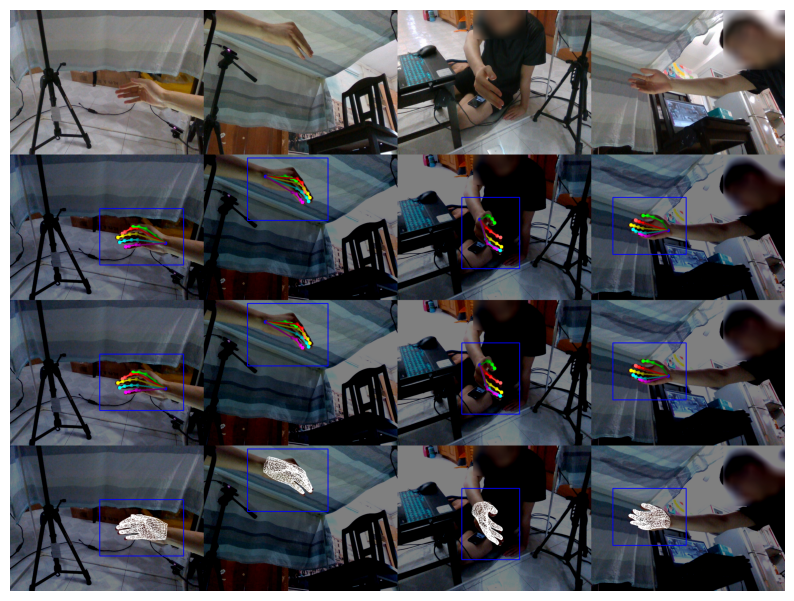

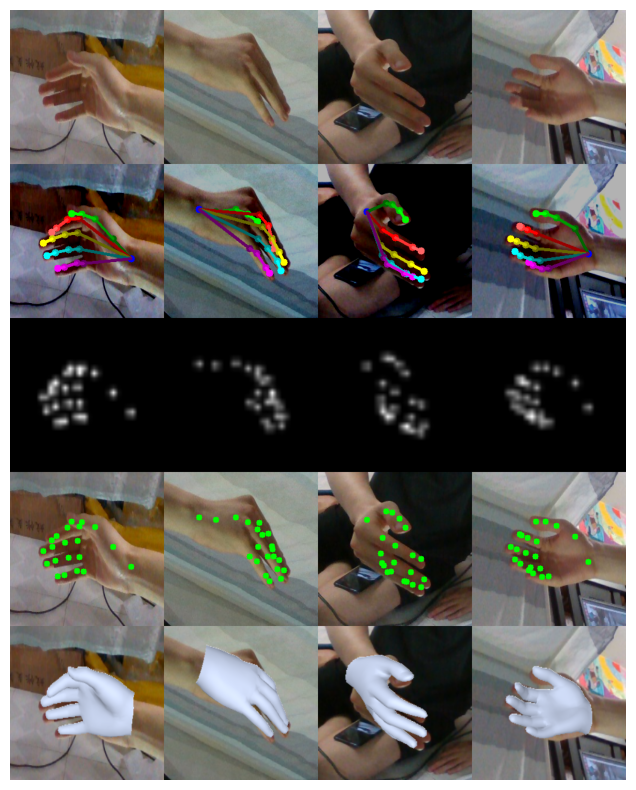

0it [00:05, ?it/s]


In [2]:
print("starting loop...")
for batch_idx, batch in tqdm(enumerate(dataloader)):
    b,views,c,h,w = batch["data"]["rgb"].shape
    idx = 0       # sample number in the batch to visualize
    vis_imgs = {
        "full": [],
        "crop": []
    }
    visualizer = HandPoseVisualizer(batch, mano_dir=config["data"]["mano_models_dir"])
    
    images = batch["data"]["full_rgb"][idx]
    crop_images = batch["data"]["rgb"][idx]
    intr = batch["cam_params"]["intrinsic"][idx]
    extr = batch["cam_params"]["extrinsic"][idx]
    bbox = batch["data"]["bboxes"][idx]
    joints_world = (batch["data"]["joints_cam"] + batch["data"]["root_joint"])[idx]
    vertices_world = (batch["data"]["all_vertices"] + batch["data"]["all_root_joints"])[idx]
    root_idx = batch["data"]["root_idx"][idx].item()

    # visualizer.visualize_3d_joints_and_vertices()
    # visualizer.visualize_3d_absolute_joints_and_vertices()
    
    vis_imgs["full"].append(visualizer.visualize_full_rgb_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_joints_2d_on_full_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_projected_joints_2d_on_full_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["full"].append(visualizer.visualize_projected_vertices_2d_on_full_image(sample_idx=idx)[:,:,::-1])

    vis_imgs["crop"].append(visualizer.visualize_rgb_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["crop"].append(visualizer.visualize_joints_2d_on_cropped_image(sample_idx=idx)[:,:,::-1])
    vis_imgs["crop"].append(visualizer.visualize_combined_heatmaps(sample_idx=idx))

    # project joints_3d to 2d on all views to check if camera parameters are correct
    proj = []
    joints2d_vis = []
    for v in range(views):
        # joints_world/1000 to convert it into meters
        joints_in_root_camera = transform_joints_between_cameras(joints_world/1000, extr[root_idx], extr[v])
        proj_joints_2d = camera_to_image_projection(joints_in_root_camera, intr[v])[:, :2]
        proj_joints_2d = batch_joints_img_to_cropped_joints(proj_joints_2d.view(-1, 21, 2), bbox[v].view(-1, 4))[0]
        img = reverse_transform(crop_images[v], denormalize=True, IMAGENET_TRANSFORM=True)
        
        for j_idx, joint in enumerate(proj_joints_2d.numpy()):
            img = cv2.circle(img.copy(), (int(joint[0]), int(joint[1])), 5, (0,255,0), -1)
        joints2d_vis.append(img)
    joints2d_vis = np.hstack(joints2d_vis)
    vis_imgs["crop"].append(joints2d_vis)

    mesh2d_vis = []
    for v in range(views):
        intrinsic = intr[v].numpy().copy()
        bb = bbox[v].numpy()
        bb_w, bb_h = bb[2] - bb[0], bb[3] - bb[1]
        intrinsic[2], intrinsic[3] = intrinsic[2] - bb[0], intrinsic[3] - bb[1]
        img = reverse_transform(crop_images[v], denormalize=True, IMAGENET_TRANSFORM=True)
        img_orig = cv2.resize(img.copy(), (bb_w, bb_h))
        mesh_2d = HandPoseVisualizer.generate_mesh_from_verts(
                            vertices_world[v],
                            np.eye(4),
                            intrinsic,
                            img_orig
                        )[0]
        mesh_2d = cv2.resize(mesh_2d, (256, 256))
        mesh2d_vis.append(mesh_2d)
    mesh2d_vis = np.hstack(mesh2d_vis)
    vis_imgs["crop"].append(mesh2d_vis)


    # # test order of the joints by visualizing one by one
    # for v in range(views):
    #     img = reverse_transform(images[v], denormalize=True, IMAGENET_TRANSFORM=True)
    #     for j in range(21):
    #         joint = batch["data"]["joints_img"][0, v, j]
    #         # print(joint)
    #         img = cv2.circle(img.copy(), (int(joint[0]), int(joint[1])), 5, (0,255,0), -1)
    #         print(j)
    #         plt.imshow(img)
    #         plt.show()
    #     break
    
    vis_full = np.vstack(vis_imgs["full"])
    vis_crop = np.vstack(vis_imgs["crop"])
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vis_full)
    plt.axis("off")
    plt.show()

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(vis_crop)
    plt.axis("off")
    plt.show()

    # dump_img = np.vstack([vis_imgs["crop"][1],joints2d_vis])
    # dump_img = cv2.resize(dump_img, (0,0), fx=0.5, fy=0.5)
    # cv2.imwrite(f"./dump/{batch_idx}_crop.png", dump_img)
    
    if batch_idx >= 0: break

# Check if Triangulation is working on Grountruths

In [3]:
from utils.triangulation import triangulate_dlt_torch
from models.metrics import PoseMetrics


def create_intrinsics_matrix(intrinsics):
    """
    Converts intrinsics tensor (num_views, 4) to K matrix (num_views, 3, 3).
    
    :param intrinsics: torch.Tensor of shape (num_views, 4) where each row is [fx, fy, cx, cy]
    :return: torch.Tensor of shape (num_views, 3, 3) representing the K matrix for each view
    """
    num_views = intrinsics.shape[0]
    K = torch.zeros((num_views, 3, 3), device=intrinsics.device)

    # Set fx, fy, cx, cy for each view in the K matrix
    K[:, 0, 0] = intrinsics[:, 0]  # fx
    K[:, 1, 1] = intrinsics[:, 1]  # fy
    K[:, 0, 2] = intrinsics[:, 2]  # cx
    K[:, 1, 2] = intrinsics[:, 3]  # cy
    K[:, 2, 2] = 1.0  # bottom-right element is always 1

    return K


for batch_idx, sample in enumerate(dataloader):
    batch_size = sample["data"]["rgb"].shape[0]
    for b in range(batch_size):
        extr = sample["cam_params"]["extrinsic"][b].float()   # [v, 4, 4]
        extr_inv = torch.linalg.inv(extr) # [v, 4, 4]
        intr = sample["cam_params"]["intrinsic"][b].float()   # [v, 4]
        if "intrinsic_mat" in sample["cam_params"]:
            Ks = sample["cam_params"]["intrinsic_mat"][b]
        else:
            Ks = create_intrinsics_matrix(intr)  # [v, 3, 3]

        crops = sample["data"]["rgb"][b]
        bbox = sample["data"]["bboxes"][b]
        gt_joints_2d = sample["data"]["joints_img"][b]
        gt_joints_crop_2d = sample["data"]["joints_crop_img"][b]
        gt_joints_cam = sample["data"]["joints_cam"][b] 
        gt_root = sample["data"]["root_joint"][b]
        gt_joints_cam_abs = gt_joints_cam + gt_root

        gt_vertices = sample["data"]["vertices"][b]
        gt_vertices_abs = gt_vertices + gt_root

        pred_joints_cam_abs = triangulate_dlt_torch(gt_joints_2d, Ks, extr_inv) * 1000

        mpjpe = PoseMetrics.mpjpe(pred_joints_cam_abs, gt_joints_cam_abs)
        pa_mpjpe = PoseMetrics.pa_mpjpe(pred_joints_cam_abs.unsqueeze(0), gt_joints_cam_abs.unsqueeze(0))
        print(f"Batch {batch_idx}, mpjpe: {mpjpe:.4f}, pa_mpjpe: {pa_mpjpe:.4f}")
        
    if batch_idx > 9: break

/home/asadali/anaconda3/envs/data2/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Batch 0, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 1, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 2, mpjpe: 0.0002, pa_mpjpe: 0.0001
Batch 3, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 4, mpjpe: 0.0002, pa_mpjpe: 0.0001
Batch 5, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 6, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 7, mpjpe: 0.0001, pa_mpjpe: 0.0001
Batch 8, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 9, mpjpe: 0.0002, pa_mpjpe: 0.0002
Batch 10, mpjpe: 0.0002, pa_mpjpe: 0.0002
